# Задача

Сравнительный анализ фреймворков для поиска параметров моделей машинного обучения. В ходе работы будут рассмотрены [10 фреймворков](https://www.kaggle.com/code/sivasaiyadav8143/10-hyperparameter-optimization-frameworks)

Каждый из фреймворков будет использован для поиска гиперпараметров заданной модели машинного обучения. Будет проведено 10 запусков для каждого фреймворка. В ходе экспериментов будут сохранены:
- среднее время поиска оптимальной модели
- средний достигнутый оптимум
- средняя скорость работы полученной модели
- то же самое, только max, min.

# Подготовка



## Подключение библиотек

In [1]:
# Python
import os
import gc
import copy
import time
import random
import logging
from numbers import Number
from typing import Tuple, List
from abc import ABC, abstractmethod

# Jupiter
from tqdm.auto import tqdm

# File work
import pickle
import joblib

# Data work
import pandas as pd

# Math
import numpy as np

# ML
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Frameworks
import ray
from ray import train, tune
import optuna
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

## Создание общих вспомогательных объектов

In [2]:
class CFG:
    '''
    Конфигурационный класс, хранящий различные константы, флаги и прочее
    '''
    # Technical
    seed = 2024

    # Train
    test_size = 0.2

    # Frameworks
    max_iter = 10
    n_trials = 25

    # Path
    general_folder_path = "../"
    data_path = f"{general_folder_path}data/"
    results_path = f"{general_folder_path}Results/"
    graphs_path = f"{general_folder_path}Graphs/"

In [3]:
#Фиксация сидов для воспроизводимости
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy

In [4]:
seed_everything(CFG.seed)

# Данные

## Обработка признаков

In [5]:
def sort_categories(counts: dict):
    labels = sorted(counts.keys(), reverse=True, key=lambda x: counts[x])
    return {key: counts[key] for key in labels}

In [6]:
def get_to_replace_same(dt, col_name):
    all_names = dt[col_name].unique()
    to_replace = {}
    for name in all_names:
        if name in to_replace.keys() or name.lower() == name:
            continue
        if name.lower() in all_names:
            to_replace[name.lower()] = name
    return to_replace

In [7]:
def get_to_replace_low(dt, col_name, count):
    low_make_mask = dt[col_name].value_counts() < count
    low_make = dt[col_name].value_counts()[low_make_mask]
    return {name: "other" for name in low_make.index}

In [8]:
filtered_dt = pd.read_csv(CFG.data_path + "filtered_dt.csv")

In [9]:
filtered_dt.head(5)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice,sale_day_of_week,sale_year,sale_day,sale_month
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,2,2014,16,12
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,2,2014,16,12
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,4,2015,15,1
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,4,2015,29,1
4,2015,Nissan,Altima,2.5 S,Sedan,automatic,ca,1.0,5554.0,gray,black,enterprise vehicle exchange / tra / rental / t...,15350.0,10900.0,2,2014,30,12


In [10]:
numerical_features = ['year', 'condition', 'odometer', 'mmr',
                      'sale_day_of_week', 'sale_year',
                      'sale_day', 'sale_month']
categorical_features = ['make', 'model', 'trim', 'body', 'transmission',
                        'state', 'color', 'interior', 'seller']
target_col = "sellingprice"

Посмотрим на количество уникальных элементов в каждом категориальном признаке

In [11]:
for col in categorical_features:
    print(f"Category count for {col} = {len(filtered_dt[col].unique())}")

Category count for make = 86
Category count for model = 863
Category count for trim = 1751
Category count for body = 82
Category count for transmission = 2
Category count for state = 38
Category count for color = 20
Category count for interior = 17
Category count for seller = 13557


In [12]:
final_dt = copy.copy(filtered_dt)

Так как количество категорий в большинстве столбцов крайне велико, попробуем уменьшить это количество.

In [13]:
col_to_squeeze = ["make", "model", "trim", "body", "seller"]

Сначала совместим однотипные названия, например в случае 'kia' и 'Kia' можно переименовать 'kia' в 'Kia', т.е. названия, отличающиеся только из-за регистра букв, будем считать одним и тем же названием

In [14]:
for col in col_to_squeeze:
    to_replace_same = get_to_replace_same(final_dt, col)
    final_dt[col] = final_dt[col].replace(to_replace_same)
    print(f"Category count for {col} = {len(final_dt[col].unique())}")

Category count for make = 56
Category count for model = 750
Category count for trim = 1692
Category count for body = 44
Category count for seller = 13557


Далее заменим категории, количество которых в столбце меньше некоего порога, на 'other'. В качестве порога будем выбирать 1-ый квартиль (0.25-квантиль) распределения количества каждой категории.

In [15]:
for col in col_to_squeeze:
    threshold = final_dt[col].value_counts().describe()["25%"]
    to_replace_low = get_to_replace_low(final_dt, col, threshold)
    final_dt[col] = final_dt[col].replace(to_replace_low)
    print(f"Category count for {col} = {len(final_dt[col].unique())}; threshold = {threshold}")

Category count for make = 43; threshold = 146.0
Category count for model = 565; threshold = 21.0
Category count for trim = 1358; threshold = 3.0
Category count for body = 34; threshold = 31.75
Category count for seller = 13557; threshold = 1.0


In [16]:
final_dt.to_csv(CFG.data_path + "final_dt.csv", index=False)

Количество категорий всё ещё достаточно велико, поэтому для кодирования категорий будем использовать [TargetEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder)

## Подготовка признаков

In [17]:
def TE(df: pd.DataFrame, columns: List[str], target: pd.Series) -> Tuple[pd.DataFrame, TargetEncoder]:
  index = df.index
  te = TargetEncoder()
  values = te.fit_transform(df[columns], target)
  labels = te.get_feature_names_in()
  df = df.drop(columns, axis=1)
  df = df.reset_index(drop=True)
  df = pd.concat([df, pd.DataFrame(values, columns=labels)], axis=1)
  df = df.set_index(index)
  return (df, te)

In [18]:
final_dt = pd.read_csv(CFG.data_path + "final_dt.csv")

In [19]:
dt_for_model, te = TE(final_dt, categorical_features, final_dt[target_col])

In [20]:
dt_for_model

,year,condition,odometer,mmr,sellingprice,sale_day_of_week,sale_year,sale_day,sale_month,make,model,trim,body,transmission,state,color,interior,seller
0,2015,5.0,16639.0,20500.0,21500.0,2,2014,16,12,11761.293257,14707.642202,10597.426576,14814.735029,12836.655635,12893.840993,13735.835712,14358.740658,15842.746703
1,2015,5.0,9393.0,20800.0,21500.0,2,2014,16,12,11761.293257,14707.642202,10597.426576,14814.735029,12836.655635,12893.840993,13735.835712,12609.020926,15842.746703
2,2014,45.0,1331.0,31900.0,30000.0,4,2015,15,1,16477.142100,15640.454848,21345.451257,11273.231886,12836.655635,12893.840993,13157.923234,14358.740658,23996.281287
3,2015,41.0,14282.0,27500.0,27750.0,4,2015,29,1,11785.773575,14053.358541,16443.305335,11273.231886,12836.655635,12893.840993,13735.835712,14358.740658,25809.736308
4,2015,1.0,5554.0,15350.0,10900.0,2,2014,30,12,11795.655477,11541.751915,11524.462756,11273.231886,12836.655635,12893.840993,13157.923234,14358.740658,10873.012337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520871,2012,26.0,35858.0,9950.0,10400.0,3,2015,8,7,11795.655477,8828.523083,9702.039848,11273.231886,12836.655635,15996.685701,13735.835712,10975.509134,13804.760984
520872,2011,39.0,66403.0,20300.0,22800.0,2,2015,7,7,16477.142100,17743.155810,21303.846154,11273.231886,12836.655635,12993.662563,13735.835712,16190.062581,17261.007463
520873,2012,5.0,54393.0,30200.0,30800.0,3,2015,8,7,22156.127775,25080.111111,8519.894737,18867.148874,12836.655635,13714.283554,13735.835712,14358.740658,15108.756361
520874,2015,38.0,16658.0,15100.0,11100.0,4,2015,9,7,11795.655477,11541.751915,11524.462756,11273.231886,12836.655635,12192.684217,13735.835712,14358.740658,10873.012337


In [21]:
te.mapping

{'make': make
  1     11761.293257
  2     16477.142100
  3     11785.773575
  4     11795.655477
  5     11173.525034
  6     15400.617030
  7     14099.456266
  8     10921.537006
  9     10961.865022
  10    14077.134811
  11    13104.237208
  12    19546.182652
  13    18742.443584
  14     8389.256485
  15    17807.563462
  16    14265.028393
  17    10211.929422
  18    12302.873204
  19    16341.546305
  20    18498.494461
  21    11993.231132
  22     9402.642084
  23    12449.329127
  24    15464.543644
  25     9671.165459
  26    11158.897540
  27    10380.831787
  28    11182.318359
  29    11447.195454
  30    15910.126257
  31    22156.127775
  32     6247.088608
  33     3911.862061
  34     8095.756216
  35     3564.413650
  36     4162.594187
  37    14915.858612
  38    13008.133970
  39    15330.034722
  40     3667.002119
  41     3952.171239
  42     1056.433225
  43     1887.789586
 -1     12761.838716
 -2     12761.838716
 dtype: float64,
 'model': model
  1     

Нормализация данных не нужна, т.к. мы будем использовать модели, основанные на решающих деревьях, а они не зависят от распределения исходных данных.

## Разделение на выборки

In [22]:
x_train, x_test, y_train, y_test = train_test_split(dt_for_model.drop(target_col, axis=1),
                                                  dt_for_model[target_col],
                                                  test_size=CFG.test_size,
                                                  random_state=CFG.seed)

In [23]:
print("Sizes")
pd.DataFrame({"Total": len(dt_for_model),
              "Train": len(x_train),
              "Test": len(x_test)}, index=[""])

Sizes


,Total,Train,Test
,520876,416700,104176


In [24]:
x_train.head(5)

,year,condition,odometer,mmr,sale_day_of_week,sale_year,sale_day,sale_month,make,model,trim,body,transmission,state,color,interior,seller
237587,2014,5.0,17783.0,30000.0,2,2015,10,2,14265.028393,21010.857630,24754.839024,14814.735029,12836.655635,17055.352480,13157.923234,14358.740658,21502.490887
387247,2014,42.0,21855.0,11900.0,3,2015,27,5,11795.655477,8828.523083,15283.317237,11273.231886,12836.655635,14840.368846,13157.923234,14358.740658,21105.627834
87695,2002,21.0,144526.0,2475.0,3,2015,18,2,14265.028393,7914.138856,11636.572031,14814.735029,12836.655635,13359.658676,11346.306478,14358.740658,2071.070553
77940,2002,19.0,89256.0,1450.0,3,2015,21,1,11158.897540,1354.315961,7108.972205,11273.231886,12836.655635,12577.367374,11106.267208,14358.740658,7621.634615
93249,2006,19.0,169154.0,1450.0,2,2015,3,2,11761.293257,13423.727606,10597.426576,11273.231886,12836.655635,14700.685369,13157.923234,10975.509134,3143.010204


# Бейзлайн

В качестве бейзлайна возьмём DecisionTreeRegressor со стандартными параметрами.

In [ ]:
scoring_fn = ["neg_mean_absolute_error", "r2"]

In [ ]:
# model = RandomForestRegressor(n_jobs=-1)
model = DecisionTreeRegressor()
cv_result = cross_validate(model, x_train, y_train, n_jobs=-1,
                           return_train_score=True,
                           scoring=scoring_fn)

In [ ]:
cv_result

{'fit_time': array([5.06074214, 5.00669289, 5.0627439 , 5.04172421, 5.02370834]),
 'score_time': array([0.09408522, 0.07607007, 0.09508634, 0.09208465, 0.07406783]),
 'test_neg_mean_absolute_error': array([-1275.24061675, -1287.80111591, -1281.76099112, -1279.51899448,
        -1281.66652268]),
 'train_neg_mean_absolute_error': array([-0., -0., -0., -0., -0.]),
 'test_r2': array([0.93655342, 0.93605488, 0.93523462, 0.93554734, 0.93554192]),
 'train_r2': array([1., 1., 1., 1., 1.])}

In [ ]:
for key, value in cv_result.items():
    print(f"Avg {key}: {value.mean()}")

Avg fit_time: 5.039122295379639
Avg score_time: 0.08627882003784179
Avg test_neg_mean_absolute_error: -1281.197648188145
Avg train_neg_mean_absolute_error: 0.0
Avg test_r2: 0.9357864369930058
Avg train_r2: 1.0


In [ ]:
model.fit(x_train, y_train)

DecisionTreeRegressor()

In [ ]:
predicted = model.predict(x_test)

In [ ]:
print(f"Test MAE: {mean_absolute_error(y_test, predicted)}")
print(f"Test R2: {r2_score(y_test, predicted)}")

Test MAE: 1277.133696820765
Test R2: 0.9353456208449169


In [ ]:
print(f"Tree depth: {model.get_depth()}")
print(f"Tree leaves number: {model.get_n_leaves()}")

Tree depth: 53
Tree leaves number: 367991


# Фреймворки

## Общее для фреймворков

### Логирование

Структура файлов выглядит примерно так:

    root/
        Results/
            Framework1/
                results.csv
                models/
                    model_0.joblib
                    model_0.joblib
                    ...
                trials/
                    trials_0.csv
                    trials_1.csv
                    ...
            Framework2/
                ...
            ...

Описание файлов:
* `results.csv` - хранит информацию по итогам каждого запуска:
    * Время:
        * Общее время поиска
        * Среднее время обучения модели
        * Среднее время валидации
        * Среднее время одной попытки
        * Финальное время на Test
    * Качество R2:
        * Среднее на train
        * Среднее на Val
        * Финальное на Test
    * Качество MAE:
        * Среднее на train
        * Среднее на Val
        * Финальное на Test
    * Лучшие найденные параметры модели (каждый параметр в отдельном столбце)
* `model.joblib` - экземпляр лучшей для данного запуска модели
* `trials.csv` - хранит историю поиска каждого запуска (параметры, качество модели)


In [25]:
class PathManager():
    def __init__(self, main_folder):
        self.folder = f"{CFG.results_path}{main_folder}/"
        self.models_folder = f"{self.folder}models/"
        self.trials_folder = f"{self.folder}trials/"
        self.results = f"{self.folder}results.csv"
        self.make_dirs("models", "trials")
        
    @property
    def trials_count(self):
        return len([name for name in os.listdir(self.trials_folder) 
                    if os.path.isfile(os.path.join(self.trials_folder, name))])
        
    def one_trials(self, idx: int):
        return f"{self.trials_folder}trials_{idx}.csv"
    
    def one_model(self, idx: int):
        return f"{self.models_folder}model_{idx}.joblib"
    
    def make_dirs(self, *folders):
        for folder in folders:
            if not os.path.exists(f"{self.folder}{folder}"):
                os.makedirs(f"{self.folder}{folder}")

In [26]:
class SaveLoader():
    def __init__(self, path_manager: PathManager):
        self._paths = path_manager
        self.__iter_count = path_manager.trials_count

    @property
    def iter_count(self):
        return self.__iter_count
    
    def next_iter(self):
        self.__iter_count += 1
    
    def save_res(self, data: dict):
        self.__form_results(data).to_csv(self._paths.results, index=False)

    def save_trial(self, trial_history: dict):
        pd.DataFrame(trial_history)\
          .to_csv(self._paths.one_trials(self.iter_count), index=False)

    def save_model(self, model):
        joblib.dump(model, self._paths.one_model(self.iter_count),
                    compress=3)

    def load_results(self):
        if self.iter_count == 0:
            raise FileNotFoundError("results.csv not exists")
        return pd.read_csv(self._paths.results, header=[0, 1])

    def load_trials(self, idx: int):
        self._idx_check(idx)
        return pd.read_csv(self._paths.one_trials(idx))

    def load_model(self, idx: int):
        self._idx_check(idx)
        return joblib.load(self._paths.one_model(idx))
    
    def __form_results(self, new_results: dict) -> pd.DataFrame:
        new_dt = pd.DataFrame({key: [value] for key, value in new_results.items()})
        if self.iter_count > 0:
            current_dt = self.load_results()
            new_dt = pd.concat([current_dt, new_dt], axis=0)\
                       .reset_index(drop=True)
        return new_dt
    
    def _idx_check(self, idx: int):
        if idx < 0 or idx >= self.iter_count:
            raise IndexError(f"idx out of range [0, {self.iter_count - 1}]")

### Model

In [27]:
def test_model(model):
    start = time.time()
    predicted = model.predict(x_test)
    end = time.time() - start
    return {("Time", "Test"): end,
            ("MAE", "Test"): mean_absolute_error(y_test, predicted),
            ("R2", "Test"): r2_score(y_test, predicted)}

In [28]:
class CVManager():
    cv_results_keys = ("Time", "Train"), ("Time", "Val"), \
                      ("MAE", "Train"), ("MAE", "Val"), \
                      ("R2", "Train"), ("R2", "Val")
    @staticmethod    
    def format_cv_results(cv_results):
        return {
            ("Time", "Train"): cv_results["fit_time"].mean(),
            ("Time", "Val"): cv_results["score_time"].mean(),
            ("MAE", "Train"): cv_results["train_neg_mean_absolute_error"].mean() * -1,
            ("MAE", "Val"): cv_results["test_neg_mean_absolute_error"].mean() * -1,
            ("R2", "Train"): cv_results["train_r2"].mean(),
            ("R2", "Val"): cv_results["test_r2"].mean(),
        }
    
    @staticmethod
    def cross_validate_model(model):
        return cross_validate(model, x_train, y_train, n_jobs=-1,
                              return_train_score=True,
                              scoring=["neg_mean_absolute_error", "r2"])


### Manager

In [29]:
class Results():
    def __init__(self, dict_keys):
        self.__values = {key: [] for key in dict_keys}
    
    @property
    def values(self) -> dict:
        return copy.deepcopy(self.__values)

    def add(self, new_dict: dict):
        for key, value in new_dict.items():
            self.__values[key].append(value)
    
    @property
    def mean(self):
        return {key: sum(value)/len(value) for key, value in self.__values.items()}

In [30]:
class FrameworkManager(ABC):
    def __init__(self, model_class, loader: SaveLoader):
        self.__model_class = model_class
        self.__loader = loader
    
    @property
    def loader(self):
        return self.__loader

    def create_model(self, *args, **kwargs):
        return self.__model_class(*args, **kwargs)

    @abstractmethod
    def one_iteration(self):
        pass
    
    def __save_all(self, model, trial_dict, data_dict):
        self.__loader.save_model(model)
        self.__loader.save_trial(trial_dict)
        self.__loader.save_res(data_dict)
        
    def __best_model(self, best_params):
        model = self.create_model(**best_params)
        model.fit(x_train, y_train)
        return model, test_model(model)
        
    def search(self):
        while self.__loader.iter_count < CFG.max_iter:
            print(f"Iter #{self.__loader.iter_count + 1}: ", end="")
            history, results, best_params = self.one_iteration()
            model, test_results = self.__best_model(best_params)
            results.update(test_results)
            self.__save_all(model, history, results)
            self.__loader.next_iter()
            print("Results saved")

### Parameters grid

Варьировать будем:
* `criterion` - критерий, используемый для обучения дерева. Доступные значения:
    * `squared_error`
    * `friedman_mse`
    * `absolute_error`
    * `poisson`
* `max_depth` - максимальная глубина (высота) дерева. По умолчанию не установлено и дерево растёт, пока не получатся "чистые" узлы или узлы, содержащие меньше, чем `min_samples_split`
* `min_samples_split`
* `min_samples_leaf`

In [31]:
params = {
    "criterion": ['squared_error', 'friedman_mse', 'poisson'],
    "max_depth": [5, 60, 5], 
    "min_samples_split": [2, 20, 1],
    "min_samples_leaf": [1, 10, 1]
}

In [32]:
count = 1
for key, value in params.items():
    values = value
    if isinstance(value[0], Number):
        values = np.arange(value[0], value[1] + 1, value[2])
    print(f"Options count for {key}: {len(values)}")
    count *= len(values)
print(f"Total options count: {count}")

Options count for criterion: 3
Options count for max_depth: 12
Options count for min_samples_split: 19
Options count for min_samples_leaf: 10
Total options count: 6840


## Ray-Tune

### Manager

In [33]:
class RayTuneConverter():
    def __init__(self, results_grid):
        self.results_grid = results_grid
        
    @staticmethod
    def __trial_to_dict(trial):
        return {
            **trial["config"],
            "Duration": trial["time_total_s"],
            "Value": trial["score"]
        }
        
    def trials_results(self):
        results = Results(CVManager.cv_results_keys)
        for trial_result in self.results_grid._results:
            cv_results = CVManager.format_cv_results(trial_result.metrics["cv_results"])
            results.add(cv_results)
        best_params = self.results_grid.get_best_result().metrics["config"]
        result = results.mean
        result.update({("Params", key): value for key, value in best_params.items()})
        return result
    
    def trials_history(self):
        results = Results(["Duration", "Value", *params.keys()])
        for result in self.results_grid._results:
            trial_dict = RayTuneConverter.__trial_to_dict(result.metrics)
            results.add(trial_dict)
        return results.values

In [34]:
def create_ray_model(manager, config):
    return ray.put(manager.create_model(**config))

In [43]:
class RayTuneObjective():
    def __init__(self, manager: FrameworkManager):
        self.manager = manager
        
    @staticmethod
    def __get_randint(name):
        return tune.qrandint(params[name][0], params[name][1], params[name][2])
    
    @staticmethod
    def __sample_split(config):
        return random.randrange(config["min_samples_leaf"] * 2,
                                params["min_samples_split"][1],
                                params["min_samples_split"][2])
    
    @property
    def space(self):
        current_space = {"criterion": tune.choice(params["criterion"])}
        for name in ["max_depth", "min_samples_leaf"]:
            current_space[name] = RayTuneObjective.__get_randint(name)
        current_space["min_samples_split"] = tune.sample_from(RayTuneObjective.__sample_split)
        return current_space

    def objective(self, config: dict):
        model = self.manager.create_model(**config)
        cv_results = CVManager.cross_validate_model(model)
        del model
        gc.collect()
        return {"score": cv_results["test_r2"].mean(), "cv_results": cv_results}

In [36]:
class CustomReporter(tune.ProgressReporter):
    def should_report(self, trials, done=False):
        return False
    def report(self, trials, done, *sys_info):
        pass

In [47]:
class RayTuneManager(FrameworkManager):
    def __init__(self, model_class):
        super().__init__(model_class, SaveLoader(PathManager("RayTune")))
        
    def __optimize(self):
        objective = RayTuneObjective(self)
        tuner = tune.Tuner(objective.objective,
                           param_space=objective.space,
                           tune_config=tune.TuneConfig(
                               metric="score",
                               mode="max",
                               num_samples=CFG.n_trials,
                               max_concurrent_trials=None
                           ),
                           run_config=train.RunConfig(
                               verbose=0,
                               progress_reporter=CustomReporter(),
                               log_to_file=False,
                               storage_path="O:\\Temp\\Ray\\Storage",
                               checkpoint_config=train.CheckpointConfig(
                                    num_to_keep=1,
                                    checkpoint_frequency=0
                                )
                           ))
        start_time = time.time()
        result_grid = tuner.fit()
        end_time = time.time() - start_time
        del tuner
        gc.collect()
        return result_grid, end_time
    
    @staticmethod
    def __format_results(result_grid, end_time):
        converter = RayTuneConverter(result_grid)
        trials_results = converter.trials_results()
        trials_results[("Time", "Iteration")] = end_time
        return converter.trials_history(), trials_results
    
    def one_iteration(self):
        result_grid, end_time = self.__optimize()
        history, results = RayTuneManager.__format_results(result_grid, end_time)
        best_params = result_grid.get_best_result().metrics["config"]
        del result_grid
        gc.collect()
        return history, results, best_params

### Search

In [45]:
manager_ray = RayTuneManager(DecisionTreeRegressor)

In [48]:
os.environ["TUNE_DISABLE_AUTO_CALLBACK_LOGGERS"] = "1"
ray.init(ignore_reinit_error=True, _temp_dir="O:\\Temp\\Ray", logging_level=logging.ERROR)
manager_ray.search()

In [49]:
results_ray = manager_ray.loader.load_results()
results_ray = results_ray.sort_index(axis=1, level=[0])
print(f"Current iterations count: {manager_ray.loader.iter_count}")
display(results_ray)
display(manager_ray.loader.load_trials(0))

Current iterations count: 10


MAE                                  Params            \
          Test       Train          Val      criterion max_depth   
0   923.203250  707.337548  1064.915165        poisson        10   
1   923.139323  685.828787  1061.097043   friedman_mse        10   
2   923.199568  686.885762  1072.279096   friedman_mse        10   
3   923.642418  661.603320  1082.948034        poisson        10   
4   923.597067  702.682382  1068.301449        poisson        10   
5   923.208597  685.875801  1062.317447   friedman_mse        10   
6   923.642418  661.605324  1082.991071        poisson        10   
7   923.436054  656.765014  1085.517764        poisson        10   
8   923.290461  693.761274  1052.362420   friedman_mse        10   
9  1042.048273  673.709257  1094.953327  squared_error        50   

                                            R2                      \
  min_samples_leaf min_samples_split      Test     Train       Val   
0                6                19  0.965636  0.979307  0.956890   
1                9                19  0.965715  0.979889  0.956963   
2                5                18  0.965680  0.979892  0.956208   
3                7                15  0.965596  0.981747  0.955819   
4                6                13  0.965577  0.979550  0.956717   
5                9                18  0.965708  0.979968  0.956888   
6                7                15  0.965596  0.981747  0.955815   
7                7                18  0.965627  0.981931  0.955636   
8                8                16  0.965696  0.980110  0.957887   
9                8                19  0.958706  0.980743  0.954970   

         Time                                
    Iteration      Test     Train       Val  
0  124.645052  0.018000  6.761841  0.059383  
1  122.040340  0.016000  6.569225  0.060213  
2  128.538316  0.017000  6.685416  0.062696  
3  127.670259  0.019003  8.024953  0.065893  
4  121.501925  0.016000  6.649590  0.060069  
5  126.817310  0.017999  7.079557  0.064978  
6  118.415039  0.015000  7.388335  0.064801  
7  121.562659  0.015001  7.040447  0.059897  
8  135.974717  0.032000  9.339295  0.186241  
9  128.499998  0.032002  6.711639  0.067985

,Duration,Value,criterion,max_depth,min_samples_split,min_samples_leaf
0,30.705266,0.959513,squared_error,45,19,9
1,25.358171,0.955983,poisson,5,7,2
2,31.470330,0.955498,squared_error,30,15,4
3,27.763220,0.957583,poisson,40,15,7
4,35.017379,0.956270,friedman_mse,5,8,4
5,19.908000,0.956659,squared_error,30,18,4
6,40.532516,0.959043,poisson,45,18,8
7,42.547483,0.957290,friedman_mse,40,18,5
8,38.364422,0.959529,poisson,40,18,9
9,32.364381,0.965963,friedman_mse,10,17,6


## Optuna

### SaveLoader

Т.к. Optuna предоставляет функционал по отрисовки различных графиков на основе объекта Study, будем дополнительно сохранять данный объект на каждой итерации. Таким образом структура файлов в случае использования Optuna будет выглядеть следующим образом

    root/
        Results/
            Optuna/
                results.csv
                models/
                    ...
                trials/
                    ...
                studies/
                    study_0.joblib
                    study_1.joblib
                    ...

In [47]:
class PathManagerOptuna(PathManager):
    def __init__(self, main_folder):
        super().__init__(main_folder)
        self.studies = f"{self.folder}studies/"
        self.make_dirs("studies")
        
    def one_study(self, idx: int):
        return f"{self.studies}study_{idx}.joblib"

In [48]:
class OptunaSaveLoader(SaveLoader):
    def __init__(self): 
        super().__init__(PathManagerOptuna("Optuna"))

    def save_study(self, study):
        joblib.dump(study, self._paths.one_study(self.iter_count),
                    compress=3)
        
    def load_study(self, idx: int):
        self._idx_check(idx)
        return joblib.load(self._paths.one_study(idx))

### Manager

In [63]:
class OptunaConverter():
    def __init__(self, study):
        self.study = study
        
    @staticmethod
    def __trial_to_dict(trial):
        return {
            **trial.params,
            "Duration": trial.duration.total_seconds(),
            "Value": trial.values[0]
        }        
    
    def study_to_dict(self):
        results = Results(CVManager.cv_results_keys)
        for trial in self.study.get_trials():
            cv_results = CVManager.format_cv_results(trial.user_attrs["cv_results"])
            results.add(cv_results)
        result = results.mean
        result.update({("Params", key): value for key, value in self.study.best_params.items()})
        return result
    
    def trials_to_dict(self):
        results = Results(["Duration", "Value" ,*params.keys()])
        for trial in self.study.get_trials():
            trial_dict = OptunaConverter.__trial_to_dict(trial)
            results.add(trial_dict)
        return results.values

In [57]:
class OptunaObjective():
    def __init__(self, manager: FrameworkManager):
        self.manager = manager
        
    @staticmethod
    def __suggest_int(trial, name: str):
        return trial.suggest_int(name,
                                 low=params[name][0],
                                 high=params[name][1],
                                 step=params[name][2])
        
    @staticmethod
    def __suggest_except_last(trial):
        current_params = {
            "criterion": trial.suggest_categorical("criterion", 
                                                   params["criterion"])
        }
        for name in ["max_depth", "min_samples_leaf"]:
            suggested = OptunaObjective.__suggest_int(trial, name)
            current_params[name] = suggested
        return current_params
    
    @staticmethod    
    def __suggest_all(trial):
        current_params = OptunaObjective.__suggest_except_last(trial)
        
        current_params["min_samples_split"] = trial.suggest_int(
            "min_samples_split",
            low=current_params["min_samples_leaf"] * 2,
            high=params["min_samples_split"][1],
            step=params["min_samples_split"][2]
        )
        
        return current_params

    def objective(self, trial):
        current_params = OptunaObjective.__suggest_all(trial)
        model = self.manager.create_model(**current_params)
        cv_results = CVManager.cross_validate_model(model)
        trial.set_user_attr("cv_results", cv_results)
        return cv_results["test_r2"].mean()

In [58]:
class OptunaManager(FrameworkManager):
    def __init__(self, model_class):
        super().__init__(model_class, OptunaSaveLoader())
        
    def __optimize(self):
        objective = OptunaObjective(self)
        study = optuna.create_study(direction="maximize")
        start_time = time.time()
        study.optimize(objective.objective, n_trials=CFG.n_trials, n_jobs=-1)
        end_time = time.time() - start_time
        return study, end_time
    
    @staticmethod
    def __format_results(study, end_time):
        converter = OptunaConverter(study)
        study_data = converter.study_to_dict()
        study_data[("Time", "Iteration")] = end_time
        return converter.trials_to_dict(), study_data
    
    def one_iteration(self):
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study, end_time = self.__optimize()
        self.loader.save_study(study)
        history, results = OptunaManager.__format_results(study, end_time)
        return history, results, study.best_params

### Search

In [64]:
manager_optuna = OptunaManager(DecisionTreeRegressor)
manager_optuna.search()

Iter #1: Results saved
Iter #2: Results saved
Iter #3: Results saved
Iter #4: Results saved
Iter #5: Results saved
Iter #6: Results saved
Iter #7: Results saved
Iter #8: Results saved
Iter #9: Results saved
Iter #10: Results saved


In [65]:
results_optuna = manager_optuna.loader.load_results()
results_optuna = results_optuna.sort_index(axis=1, level=[0])
print(f"Current iterations count: {manager_optuna.loader.iter_count}")
display(results_optuna)
display(manager_optuna.loader.load_trials(0))

Current iterations count: 10


MAE                                  Params            \
         Test       Train          Val      criterion max_depth   
0  923.618345  666.237855  1080.848741        poisson        10   
1  923.139323  667.481324  1073.913442   friedman_mse        10   
2  924.417752  691.359957  1072.055942  squared_error        10   
3  922.935615  674.268555  1075.027143        poisson        10   
4  923.208597  661.167917  1089.616970   friedman_mse        10   
5  923.208597  751.288980  1040.262260   friedman_mse        10   
6  922.873940  700.568131  1066.583737        poisson        10   
7  923.117705  740.715930  1048.624104   friedman_mse        10   
8  923.065610  708.136217  1053.520500   friedman_mse        10   
9  924.465785  745.993795  1063.618397        poisson        10   

                                            R2                           Time  \
  min_samples_leaf min_samples_split      Test     Train       Val  Iteration   
0                6                13  0.965576  0.980635  0.955295  47.729216   
1                9                19  0.965715  0.981011  0.956341  47.302040   
2                4                 8  0.965479  0.979761  0.956531  44.905060   
3                8                18  0.965728  0.980310  0.955932  46.803096   
4                9                18  0.965708  0.981246  0.955268  50.352352   
5                9                18  0.965708  0.977345  0.959024  46.366575   
6               10                20  0.965748  0.979319  0.957032  45.680176   
7                8                18  0.965718  0.976788  0.957893  41.506216   
8                8                20  0.965720  0.979249  0.957845  44.980686   
9                3                14  0.965480  0.977118  0.957247  42.158018   

                                 
       Test     Train       Val  
0  0.014999  5.344097  0.052876  
1  0.014999  5.555303  0.055073  
2  0.016001  5.267986  0.055521  
3  0.016000  5.501032  0.052335  
4  0.015997  5.659755  0.054809  
5  0.015999  5.311623  0.050033  
6  0.015001  5.394302  0.051233  
7  0.015000  4.830039  0.044423  
8  0.015002  5.012455  0.047009  
9  0.015998  4.839518  0.046145

,Duration,Value,criterion,max_depth,min_samples_split,min_samples_leaf
0,7.798089,0.956393,squared_error,20,10,5
1,31.345094,0.954478,squared_error,35,13,4
2,35.732234,0.938485,friedman_mse,40,4,1
3,35.083236,0.953552,poisson,25,19,1
4,24.086256,0.952108,poisson,30,9,4
5,28.898253,0.957235,friedman_mse,30,16,6
6,32.971240,0.962485,friedman_mse,15,15,3
7,27.769258,0.956913,squared_error,25,18,4
8,20.049195,0.956549,poisson,30,14,6
9,27.075255,0.948041,poisson,60,12,1


In [66]:
results_optuna["R2"].sort_values("Test", ascending=False)

,Test,Train,Val
6,0.965748,0.979319,0.957032
3,0.965728,0.980310,0.955932
8,0.965720,0.979249,0.957845
7,0.965718,0.976788,0.957893
1,0.965715,0.981011,0.956341
4,0.965708,0.981246,0.955268
5,0.965708,0.977345,0.959024
0,0.965576,0.980635,0.955295
9,0.965480,0.977118,0.957247
2,0.965479,0.979761,0.956531


## Hyperopt

### Manager

In [155]:
class HyperoptParamConverter():        
    @staticmethod
    def get_from_fraction(current_params: dict):
        leaf_value = current_params['min_samples_leaf'] * 2
        leaf_value *= 1 - current_params["split_fraction"]
        split_value = params["min_samples_split"][1]
        split_value *= current_params["split_fraction"]
        return int(leaf_value + split_value)
    
    @staticmethod
    def format_space(current_params: dict):
        return {
            "criterion": params["criterion"][current_params["criterion"]],
            "max_depth": int(current_params["max_depth"]),
            "min_samples_leaf": int(current_params["min_samples_leaf"]),
            "min_samples_split": HyperoptParamConverter.get_from_fraction(current_params)
        }
        
    @staticmethod
    def extract_params(trial):
        return {key: value[0] for key, value in trial['misc']["vals"].items()}

In [145]:
class HyperoptConverter():
    def __init__(self, trials):
        self.trials = trials
        
    @staticmethod
    def __trial_to_dict(trial):
        trial_params = HyperoptParamConverter.extract_params(trial)
        trial_duration = trial['refresh_time'] - trial['book_time']
        return {
            **HyperoptParamConverter.format_space(trial_params),
            "Duration": trial_duration.total_seconds(),
            "Value": -1*trial["result"]["loss"]
        }
        
    def trials_results(self):
        results = Results(CVManager.cv_results_keys)
        for trial_result in self.trials.results:
            cv_results = CVManager.format_cv_results(trial_result["cv_results"])
            results.add(cv_results)
        best_params = HyperoptParamConverter.format_space(self.trials.argmin)
        result = results.mean
        result.update({("Params", key): value for key, value in best_params.items()})
        return result
    
    def trials_history(self):
        results = Results(["Duration", "Value", *params.keys()])
        for trial in self.trials.trials:
            trial_dict = HyperoptConverter.__trial_to_dict(trial)
            results.add(trial_dict)
        return results.values

In [129]:
class HyperoptObjective():
    def __init__(self, manager: FrameworkManager):
        self.manager = manager
        
    @staticmethod
    def __get_uniformint(name):
        return scope.int(hp.quniform(name, params[name][0], params[name][1], params[name][2]))
    
    @property
    def space(self):
        current_space = {"criterion": hp.choice("criterion", params["criterion"])}
        for name in ["max_depth", "min_samples_leaf"]:
            current_space[name] = HyperoptObjective.__get_uniformint(name)
        current_space["split_fraction"] = hp.uniform("split_fraction", 0, 1)
        return current_space

    def objective(self, current_params: dict):
        current_params["min_samples_split"] = HyperoptConverter.get_from_fraction(current_params)
        current_params.pop("split_fraction")
        model = self.manager.create_model(**current_params)
        cv_results = CVManager.cross_validate_model(model)
        return {"loss": -cv_results["test_r2"].mean(), "status": STATUS_OK,
                "cv_results": cv_results}

In [158]:
class HyperoptManager(FrameworkManager):
    def __init__(self, model_class):
        super().__init__(model_class, SaveLoader(PathManager("Hyperopt")))
        
    def __optimize(self):
        objective = HyperoptObjective(self)
        trials = Trials()
        start_time = time.time()
        fmin(objective.objective, space=objective.space,
             algo=tpe.suggest, max_evals=CFG.n_trials, trials=trials,
             verbose=False)
        end_time = time.time() - start_time
        return trials, end_time
    
    @staticmethod
    def __format_results(trials, end_time):
        converter = HyperoptConverter(trials)
        trials_results = converter.trials_results()
        trials_results[("Time", "Iteration")] = end_time
        return converter.trials_history(), trials_results
    
    def one_iteration(self):
        trials, end_time = self.__optimize()
        history, results = HyperoptManager.__format_results(trials, end_time)
        return history, results, \
            HyperoptParamConverter.format_space(trials.argmin)

### Search

In [163]:
manager_hyperopt = HyperoptManager(DecisionTreeRegressor)
manager_hyperopt.search()

Iter #2: Results saved
Iter #3: Results saved
Iter #4: Results saved
Iter #5: Results saved
Iter #6: Results saved
Iter #7: Results saved
Iter #8: Results saved
Iter #9: Results saved
Iter #10: Results saved


In [164]:
results_hyperopt = manager_hyperopt.loader.load_results()
results_hyperopt = results_hyperopt.sort_index(axis=1, level=[0])
print(f"Current iterations count: {manager_hyperopt.loader.iter_count}")
display(results_hyperopt)
display(manager_hyperopt.loader.load_trials(0))

Current iterations count: 10


MAE                                  Params            \
         Test       Train          Val      criterion max_depth   
0  924.676101  720.597592  1055.605355        poisson        10   
1  923.329035  745.410720  1042.422258  squared_error        10   
2  922.995445  702.155318  1063.420176  squared_error        10   
3  922.873940  727.102550  1042.367694        poisson        10   
4  923.618345  754.058661  1043.851284        poisson        10   
5  924.041006  734.305259  1059.434584        poisson        10   
6  923.473442  717.215746  1049.777287        poisson        10   
7  922.995445  741.582495  1046.096828   friedman_mse        10   
8  924.171155  740.137500  1039.099271        poisson        10   
9  923.139323  762.206659  1033.178233  squared_error        10   

                                            R2                           Time  \
  min_samples_leaf min_samples_split      Test     Train       Val  Iteration   
0                4                10  0.965441  0.978188  0.957581  96.546330   
1                8                16  0.965693  0.977152  0.958499  96.225927   
2               10                20  0.965727  0.978913  0.956991  93.599277   
3               10                20  0.965748  0.977304  0.958156  96.627394   
4                6                13  0.965576  0.976297  0.958339  94.781312   
5                3                19  0.965545  0.977920  0.957479  92.536626   
6                6                16  0.965588  0.978134  0.957763  92.237791   
7               10                20  0.965727  0.977427  0.958359  88.294061   
8                3                18  0.965530  0.977069  0.958494  88.404720   
9                9                19  0.965715  0.976477  0.959297  90.912306   

                                 
       Test     Train       Val  
0  0.016000  3.300850  0.034623  
1  0.018012  3.283451  0.033492  
2  0.016000  3.308044  0.037088  
3  0.015001  3.417544  0.034623  
4  0.015999  3.349190  0.034727  
5  0.014000  3.295723  0.034048  
6  0.014999  3.271606  0.035809  
7  0.015000  3.136076  0.033376  
8  0.015997  3.105363  0.033904  
9  0.017000  3.204753  0.034125

,Duration,Value,criterion,max_depth,min_samples_split,min_samples_leaf
0,5.174,0.953527,squared_error,20,7,3
1,5.739,0.956368,poisson,35,15,5
2,4.846,0.958364,friedman_mse,30,18,7
3,4.619,0.954360,friedman_mse,55,11,5
4,4.573,0.957303,poisson,55,14,7
5,3.923,0.957546,squared_error,45,17,6
6,4.826,0.955991,poisson,35,14,5
7,5.186,0.950743,poisson,55,9,3
8,3.668,0.960785,friedman_mse,20,20,10
9,4.337,0.959362,poisson,20,18,6


## mlmachine

## Polyaxon

## Bayesian Optimization

## Talos

## SHERPA

## Scikit-Optimize

## GPyOpt

# Анализ

### Визуализация

In [ ]:
def find_best(res):
  values = res["value"]
  y = [values[0]]
  for value in values.values[1:]:
    if value > y[-1]:
      y.append(value)
    else:
      y.append(y[-1])
  return y

Восстановление результатов из файла

In [ ]:
optuna_res = pd.read_csv("optuna_res.csv")
hyperopt_res = pd.read_csv("hyperopt_res.csv")

In [ ]:
study = joblib.load("study.pkl")
with open("hyperopt_trials.p", "rb") as f:
  result_grid = pickle.load(f)

Сравнение средних времён работы каждой итерации поиска

In [ ]:
print(f"Mean duration of Optuna trail: {optuna_res['duration'].mean()}")
print(f"Mean duration of Hyperopt trail: {hyperopt_res['duration'].mean()}")

Mean duration of Optuna trail: 45.94533521999999
Mean duration of Hyperopt trail: 32.43484


In [ ]:
optuna.visualization.plot_optimization_history(study)

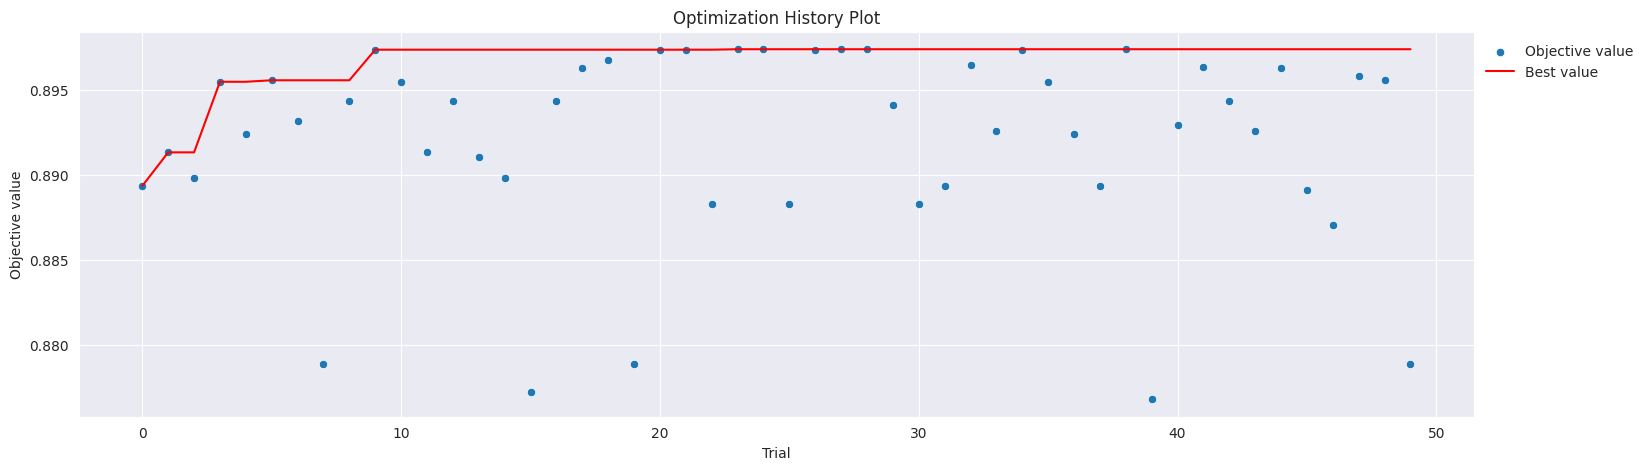

In [ ]:
y_best_hyperopt = find_best(hyperopt_res)
with sns.axes_style("darkgrid"):
  fig = plt.figure(figsize=(18, 5))
  ax = sns.scatterplot(hyperopt_res["value"])
  ax = sns.lineplot(x=hyperopt_res.index, y=y_best_hyperopt, color="r")
  plt.legend(["Objective value", "Best value"], bbox_to_anchor=(1, 1), frameon=False)
  plt.title("Optimization History Plot")
  ax.set_xlabel("Trial")
  ax.set_ylabel("Objective value")
  plt.yticks(np.arange(round(min(hyperopt_res["value"]), 2),
                       max(hyperopt_res["value"]),
                       0.005))

In [ ]:
optuna_max = optuna_res["value"].max()
hyperopt_max = hyperopt_res["value"].max()
print(f"Optuna max value: {optuna_max}")
print(f"Hyperopt max value: {hyperopt_max}")

Optuna max value: 0.8973996690970989
Hyperopt max value: 0.8973944007233868


Сравнения количества дублирующихся значений

In [ ]:
model_parameters = ["n_neighbors", "leaf_size", "p"]

In [ ]:
print(f"Optuna duplicated params: {optuna_res[model_parameters].duplicated().sum()}")
print(f"Hyperopt duplicated params: {hyperopt_res[model_parameters].duplicated().sum()}")

Optuna duplicated params: 10
Hyperopt duplicated params: 6


In [ ]:
print(f"Optuna duplicated values: {optuna_res['value'].duplicated().sum()}")
print(f"Hyperopt duplicated values: {hyperopt_res['value'].duplicated().sum()}")

Optuna duplicated values: 25
Hyperopt duplicated values: 23


In [ ]:
optuna_mask = optuna_res['value'] == optuna_max
hyperopt_mask = hyperopt_res['value'] == hyperopt_max
print(f"Optuna duplicated max value: {optuna_mask.sum()}")
print(f"Hyperopt duplicated max value: {hyperopt_mask.sum()}")

Optuna duplicated max value: 7
Hyperopt duplicated max value: 5


In [ ]:
optuna.visualization.plot_contour(study, params=model_parameters[:2])

In [ ]:
optuna.visualization.plot_contour(study, params=model_parameters[::2])

In [ ]:
optuna.visualization.plot_contour(study, params=model_parameters[1:])

In [ ]:
optuna.visualization.plot_param_importances(study)

Из вышепреведенного графика видно, что наибольшее влияние на качество работы модели оказывает количество соседей. Размер листа оказывает незначителньое значение, а параметр p - практически не влияет на качество классификации.

Всё это справедливо, разумеется, лишь для данного датасета и выбранных диапазонов изменения параметров.